<a href="https://colab.research.google.com/github/lorishoxhaj6/HumanCentered-DigitalTwin/blob/main/ModelsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HC-DTs Model Analysis
---
### **Performance. Precision. Optimization.**

A comparative study designed to isolate the model architecture that delivers the highest benefit-to-cost ratio for our system in different scenarios.

# 🗂️ Project Structure
---

The project is organized in Google Drive as follows:

```text
/MyDrive/HC-DTs_ModelsAnalysis
├── 📂 datasets
│   ├── 📂 train       # Training images/labels
│   ├── 📂 val         # Validation images/labels
│   └── 📂 runs        # Experiment tracking
│       ├── 📂 train   # Training logs with different hyperparameters configurations
│       └── 📂 val     # Validation logs

### Utility Functions for YOLO Model Testing

In [1]:
from google.colab import drive
# 1. mount the drive
drive.mount('/content/gdrive')
# 2. Define root directory globally
ROOT_DIR = '/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis'
# 3. Install Ultralytics
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.5/112.6 GB disk)


In [2]:
import argparse
import os
import shutil
from ultralytics import YOLO

def trainModel(opt):
    # 1. Determinismo (Fondamentale per la riproducibilità)
    # Impostare un seed fisso assicura che la randomizzazione sia identica
    SEED = 10

    # controllo esistenza path
    assert os.path.exists(ROOT_DIR),"ROOT_DIR non impostato"

    assert opt is not None, "opt is None"

    # 2. Gestione Path
    data_custom_path = os.path.join(ROOT_DIR, "datasets")
    data_custom_path = os.path.join(data_custom_path,opt.data_yaml)

    print(data_custom_path)
    assert opt.data_yaml is not None, "opt.data_yaml è None"

    assert os.path.exists(data_custom_path), "data_path non esiste"

    project_path = os.path.join(ROOT_DIR, "runs/train")
    run_dir = os.path.join(project_path, opt.exp_name)

    # Se la cartella esiste già, la eliminiamo completamente
    if os.path.exists(run_dir):
        print(f"Cartella esistente trovata: {run_dir}. Rimozione in corso...")
        shutil.rmtree(run_dir)

    print(f"Avvio training con configurazione: {opt}")

    # 3. Load Model
    model = YOLO(opt.model)

    # 4. Train
    results = model.train(
        data=data_custom_path,
        epochs=opt.epochs,
        imgsz=opt.imgsz,
        batch=opt.batch,
        project=os.path.join(ROOT_DIR, "runs/train"),
        name=opt.exp_name,
        seed=SEED,        # per riproducibilità
        deterministic=True,
        exist_ok=True
    )

    box_metrics = results.box

    assert (box_metrics is not None), "box_metrics is equal None"


    custom_metrics = {
        "model_name": opt.exp_name,
        "mAP50":box_metrics.map50,
        "mAP50-95":box_metrics.map,
        "precision_mean":box_metrics.mp,
        "recall_mean":box_metrics.mr
    }

    # verify that we have a class
    if len(box_metrics.r) > 0:
      try:
            custom_metrics['recall_awake'] = box_metrics.r[0]
            custom_metrics['recall_drowsiness'] = box_metrics.r[1]
      except IndexError:
          print("index class not found")


    for metric in custom_metrics.values():
      assert metric is not None, f"{metric} is None"

    return custom_metrics

In [3]:
from pickleshare import Path
from IPython.display import Image, display
import matplotlib.pyplot as plt

def plot_results(ROOT_DIR,config,runDir,train):
  files = [
      'results.png',
      'confusion_matrix.png',
      'confusion_matrix_normalized.png',
      'BoxF1_curve.png',
      'BoxPR_curve.png'
  ]

  assert os.path.exists(ROOT_DIR),"In plot_results ROOT_DIR doesn't exists"
  assert config != None, "In plot_results config is None"

  # composing path for results
  if train:
    path = os.path.join(ROOT_DIR,"runs","train",(runDir+'_'+config))
  else:
    path = os.path.join(ROOT_DIR,"runs","val",(runDir+'_'+config))

  print(path)
  assert os.path.exists(path),"In plot_results runs path doesn't exists"

  for file in files:
  # Selecting file.png in the directory
    path = os.path.join(path,file)
    print(f"{file.removesuffix(".png")}:\n")
    display(Image(filename=path))
    path = os.path.dirname(path)

In [4]:
class Options:

  def __init__(self,model,data_yamal,epochs,batch,imgsz,exp_name) -> None:
    self.model = model
    self.data_yaml = data_yamal
    self.epochs = epochs
    self.batch = batch
    self.imgsz = imgsz
    self.exp_name = exp_name

  def __str__(self) -> str:
        return f"Options[model = {self.model}, data_yaml = {self.data_yaml},epochs = {self.epochs},batch = {self.batch},imgsz = {self.imgsz}, exp_name = {self.exp_name}]"



## Training



In [5]:
# Define a set of hyperparameters to try for everey run with a specific model

hyperparameters_to_try = [
  {"NAME":"h_100_8","EPOCH" : 100,"BATCH_SIZE":8, "IMGSZ":640},
  {"NAME":"h_100_16","EPOCH" : 100,"BATCH_SIZE":16, "IMGSZ":640},
  {"NAME":"h_100_32","EPOCH" : 100,"BATCH_SIZE":32, "IMGSZ":640},
  {"NAME":"h_150_8","EPOCH" : 150,"BATCH_SIZE":8, "IMGSZ":640},
  {"NAME":"h_150_16","EPOCH" : 150,"BATCH_SIZE":16, "IMGSZ":640},
  {"NAME":"h_150_32","EPOCH" : 150,"BATCH_SIZE":32, "IMGSZ":640},
  {"NAME":"h_200_32","EPOCH" : 200,"BATCH_SIZE":32, "IMGSZ":640},
  {"NAME":"h_200_64","EPOCH" : 200,"BATCH_SIZE":64, "IMGSZ":640},
  {"NAME":"h_200_128","EPOCH" : 200,"BATCH_SIZE":128, "IMGSZ":640},
]

In [6]:
models_to_test = [
  "yolov8n",
  "yolo11n",
  "yolov3-tiny.pt",
  "yolov3u.pt",
  "yolov5n.pt",
  "yolov9t.pt",
  "yolov9s.pt"
]

In [7]:
# Define name of trainging logs folders
export_dir = {
    "yolov8n":"yolov8n",
    "yolo11n": "yolo11n",
    "yolov3-tiny.pt":"yolov3-tiny",
    "yolov3u.pt": "yolov3u",
    "yolov5n.pt": "yolov5n",
    "yolov9t.pt": "yolov9t",
    "yolov9s.pt": "yolov9s"
}

# Code below for training one model with one specific configuration of hyperparameters ⤵

In [ ]:
# we use index to access the configuration of hyperparameters from the list of
# dictionaries hyperparameters_to_try and we do the same for the dictionarie
# models_to_test

opt = Options(models_to_test[0],'data_custom.yaml',hyperparameters_to_try[0]["EPOCH"],
              hyperparameters_to_try[0]["BATCH_SIZE"],hyperparameters_to_try[0]["IMGSZ"],
              export_dir[models_to_test[0]]+'_'+hyperparameters_to_try[0]["NAME"])

trainModel(opt)

/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/datasets/data_custom.yaml
Avvio training con configurazione: Options[model = yolov8n, data_yaml = data_custom.yaml,epochs = 100,batch = 8,imgsz = 640, exp_name = yolov8n_h_100_8]
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/datasets/data_custom.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, l

KeyboardInterrupt: 

# Code below for training all `models_to_test` with different `hyperparameters_to_try` ⤵

In [ ]:
for model in models_to_test:
  for config in hyperparameters_to_try:
    print(f'training model {model} with configuration {config["NAME"]}')


    opt = Options(model,'data_custom.yaml',config["EPOCH"],config["BATCH_SIZE"],config["IMGSZ"],export_dir[model]+'_'+config["NAME"])
    metrics_dict = trainModel(opt)

training model yolov8n with configuration h_100_8
/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/datasets/data_custom.yaml
Avvio training con configurazione: Options[model = yolov8n, data_yaml = data_custom.yaml,epochs = 100,batch = 8,imgsz = 640, exp_name = yolov8n_h_100_8_]
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/datasets/data_custom.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7,

KeyboardInterrupt: 

# Visualization
Commands:
* config = select the configuration of hyperparameters
* j = select the model

# What will it display?

```
files = [
      'results.png',
      'confusion_matrix.png',
      'confusion_matrix_normalized.png',
      'BoxF1_curve.png',
      'BoxPR_curve.png'
  ]
```



In [ ]:
# Visualization
config = "h_100_8"
j = 0

# Visualization of the results
print("Results of Model: ",models_to_test[j],"configuration: ",config)
plot_results(ROOT_DIR,config,export_dir[models_to_test[j]],True)

Results of Model:  yolov8n configuration:  h_100_8
/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/runs/train/yolov8n_h_100_8
results:



FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/runs/train/yolov8n_h_100_8/results.png'

In [8]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [9]:
from ultralytics import YOLO

model_to_evaluate = "yolov8n"
config = "h_150_16"

# Select path of the weights of the model you want to evaluate
path_val = os.path.join(ROOT_DIR,model_to_evaluate+'_'+config)

assert os.path.exists(path_val), "path_val is None"

# Load the model
model = YOLO(path_val)

# Validate the model
metrics = model.val(
    data="/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/datasets/data_custom.yaml",
    project="/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/runs/val",
    name = model_to_evaluate
)

plot_results(ROOT_DIR,config,export_dir[model_to_evaluate],False)

AssertionError: path_val is None

### Utility Functions for Faster R-CNN Model training and testing

In [10]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []

    # Se train = True add some utils transformation for training
    if train:
        # illumination can change
        transforms.append(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4))
        # possibly blur
        transforms.append(T.RandomAdjustSharpness(sharpness_factor=0.3, p=0.2))


    # Standard
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float32, scale=True))


    return T.Compose(transforms)

In [11]:
import torch
import os
from PIL import Image
from torchvision import tv_tensors
from torch.utils.data import Dataset

class DigitalTwinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Gestione flessibile delle cartelle
        self.img_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        if not os.path.exists(self.label_dir):
            self.label_dir = self.img_dir # Cerca labels nella stessa cartella se manca 'labels'

        # Filtra solo le immagini
        self.images = [f for f in os.listdir(self.img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 1. Caricamento Immagine
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        w_img, h_img = image.size

        # 2. Caricamento Label (File .txt YOLO)
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_name)

        boxes_list = []
        labels_list = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()
                # YOLO format: class_id, center_x, center_y, width, height (0-1)
                class_id = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])

                # --- CONVERSIONE YOLO -> PIXEL (XYXY) ---
                # 1. Denormalizza (da 0-1 a pixel)
                cx *= w_img
                cy *= h_img
                bw *= w_img
                bh *= h_img

                # 2. Calcola angoli (x1, y1, x2, y2)
                x1 = cx - (bw / 2)
                y1 = cy - (bh / 2)
                x2 = cx + (bw / 2)
                y2 = cy + (bh / 2)

                # 3. Importante: Aggiustamento Classi
                # Faster R-CNN riserva 0 allo sfondo.
                # Se i tuoi txt hanno 0=Sveglio, 1=Dorme, dobbiamo fare +1
                # Quindi: 0(Sfondo), 1(Sveglio), 2(Dorme)
                final_label = class_id + 1

                boxes_list.append([x1, y1, x2, y2])
                labels_list.append(final_label)

        if not boxes_list:
             # Esempio: Box fittizia [0,0,1,1] classificata come sfondo (0) o ignora immagine
             boxes_list = [[0.0, 0.0, 1.0, 1.0]]
             labels_list = [0]

        # Converti in Tensori
        boxes_tensor = torch.as_tensor(boxes_list, dtype=torch.float32)
        labels_tensor = torch.as_tensor(labels_list, dtype=torch.int64)

        # Wrap per le trasformazioni v2 (fondamentale per ruotare le box!)
        target_boxes = tv_tensors.BoundingBoxes(
            boxes_tensor,
            format="XYXY",
            canvas_size=(h_img, w_img)
        )

        # 3. Applica Trasformazioni (Immagine + Box insieme)
        if self.transform:
            image, target_boxes = self.transform(image, target_boxes)

        # 4. Crea il Target Finale
        target = {}
        target["boxes"] = target_boxes
        target["labels"] = labels_tensor
        target["image_id"] = torch.tensor([idx])

        # Calcolo area (opzionale ma utile per COCO evaluation)
        target["area"] = (target_boxes[:, 3] - target_boxes[:, 1]) * (target_boxes[:, 2] - target_boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(labels_tensor),), dtype=torch.int64)

        return image, target

In [12]:
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_my_model(model, num_classes):
    """
    Sostituisce la testa (predictor) di un modello Faster R-CNN generico
    per adattarlo al numero di classi specificato.

    Args:
        model: Un modello Faster R-CNN (es. ResNet50, MobileNetV3, ecc.)
        num_classes: Il numero di classi del tuo dataset (incluso lo sfondo)
    """

    # 1. Controlliamo se il modello ha la struttura che ci aspettiamo
    # (Ovvero se è una variante di Faster R-CNN)
    if not hasattr(model, 'roi_heads'):
        raise ValueError("Il modello passato non sembra essere una Faster R-CNN!")

    try:
        in_features = model.roi_heads.box_predictor.cls_score.in_features
    except AttributeError:
        raise AttributeError("Impossibile trovare 'in_features' nel box_predictor.")

    # 3. Sostituzione output layer
    # Creiamo una nuova testa con lo STESSO numero di input (in_features)
    # ma con il NUOVO numero di output (num_classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def show_inference(img_tensor, prediction, threshold=0.5):
    """
    img_tensor: L'immagine (Tensor)
    prediction: Il dizionario uscito dal modello
    threshold: Soglia di sicurezza (es. 0.5 = 50%). Mostra solo predizioni sicure.
    """
    # 1. Converti l'immagine da Tensore (C, H, W) a Numpy (H, W, C) per disegnarla
    img = img_tensor.cpu().permute(1, 2, 0).numpy()

    # Crea la figura
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)

    # 2. Estrai i dati dalla predizione
    boxes = prediction['boxes'].cpu().detach().numpy()
    scores = prediction['scores'].cpu().detach().numpy()
    labels = prediction['labels'].cpu().detach().numpy()

    # 0 è sempre sfondo.
    class_map = {1: "Awake", 2: "Drowsy"}

    # Colori: Verde per Sveglio, Rosso per Dorme
    color_map = {1: 'lime', 2: 'red'}

    found_something = False

    # 3. Disegna ogni box
    for i, score in enumerate(scores):
        if score > threshold:
            found_something = True
            box = boxes[i]
            label_id = labels[i]

            # Coordinate
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Scelta colore ed etichetta
            color = color_map.get(label_id, 'blue')
            label_text = class_map.get(label_id, f"Class {label_id}")

            # Crea il rettangolo
            rect = patches.Rectangle((x1, y1), width, height, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # Aggiungi etichetta con sfondo colorato per leggibilità
            plt.text(x1, y1 - 5, f"{label_text}: {score:.2f}", color='white', fontsize=12, fontweight='bold',
                     bbox=dict(facecolor=color, alpha=0.5))

    plt.axis('off') # Nascondi gli assi
    plt.show()

    if not found_something:
        print("Nessun oggetto rilevato sopra la soglia.")

In [15]:
def debug_dataset(dataset):
# we look if the boxes are correct
  print("Controllo integrità dataset...")
  for i in range(10):
    img_tensor, target = dataset[i] # take first image

    print(f"Labels: {target['labels']}")
    print(f"Boxes: {target['boxes']}")


    dummy_prediction = {
        'boxes': target['boxes'],
        'scores': torch.ones(len(target['labels'])), # fake scores
        'labels': target['labels']
    }

    show_inference(img_tensor, dummy_prediction)

In [24]:
import os
from torch.utils.data import DataLoader

ROOT_DIR = "/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/datasets"

assert os.path.exists(ROOT_DIR), "ROOT_DIR doesn't exsist"
#TrainSet path
trainSet_path = os.path.join(ROOT_DIR,"train")
#TestSet path
#testSet_path = os.path.join(ROOT_DIR,"val")

# Hyperparameters.
EPOCHS = [200,300,400,500]
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
data_transform = get_transform(True)


Caricamento Dataset...
Controllo integrità dataset...
Labels: tensor([2])
Boxes: BoundingBoxes([[ 874.0003,  365.0005, 1149.0000,  746.0003]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


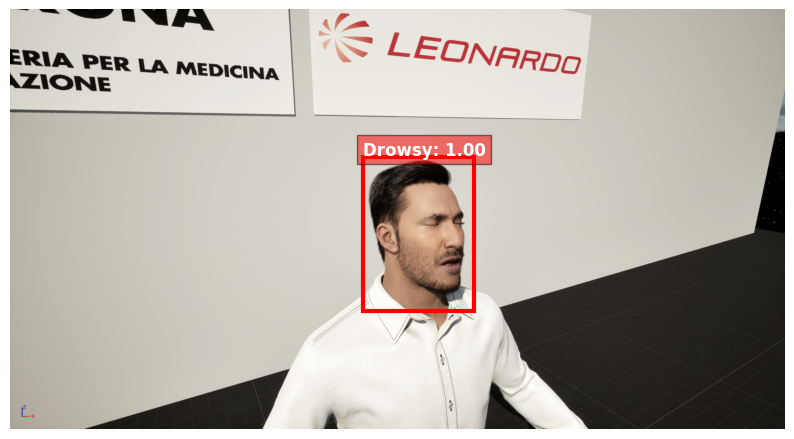

Labels: tensor([2])
Boxes: BoundingBoxes([[1117.0004,  261.0000, 1419.0010,  671.0002]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


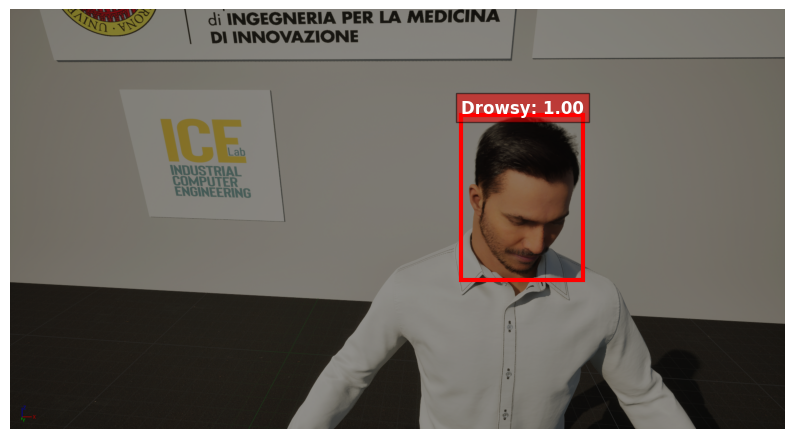

Labels: tensor([1])
Boxes: BoundingBoxes([[1126.0004,  250.9998, 1391.0006,  683.9997]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


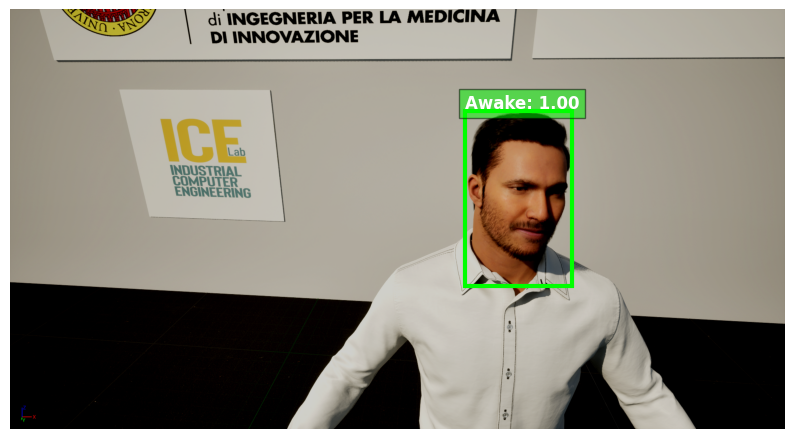

Labels: tensor([2])
Boxes: BoundingBoxes([[1119.0000,  238.9998, 1386.0010,  675.0001]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


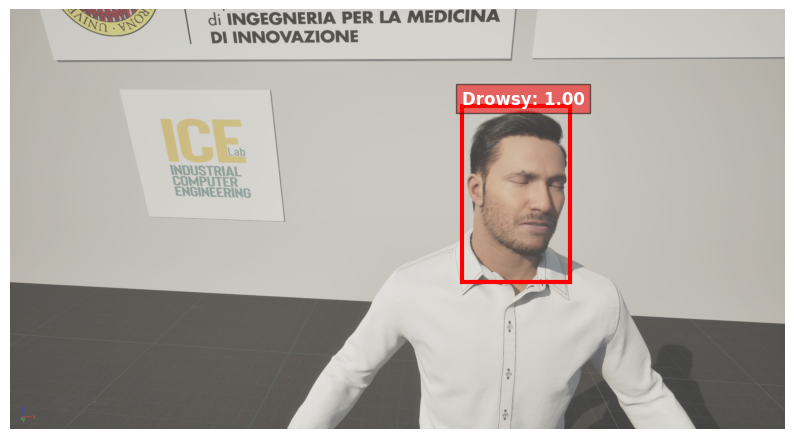

Labels: tensor([1])
Boxes: BoundingBoxes([[ 979.0003,  241.9997, 1228.9996,  661.9995]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


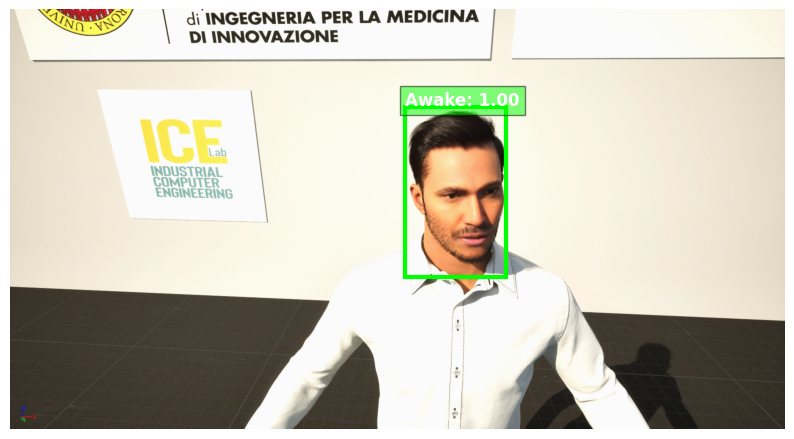

Labels: tensor([2])
Boxes: BoundingBoxes([[1126.9996,  249.0004, 1393.0004,  684.0002]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


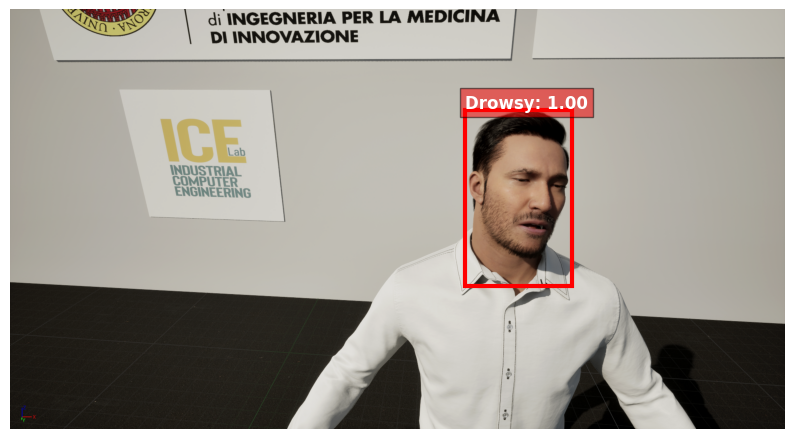

Labels: tensor([2])
Boxes: BoundingBoxes([[ 984.0010,  249.0004, 1247.0006,  676.0005]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


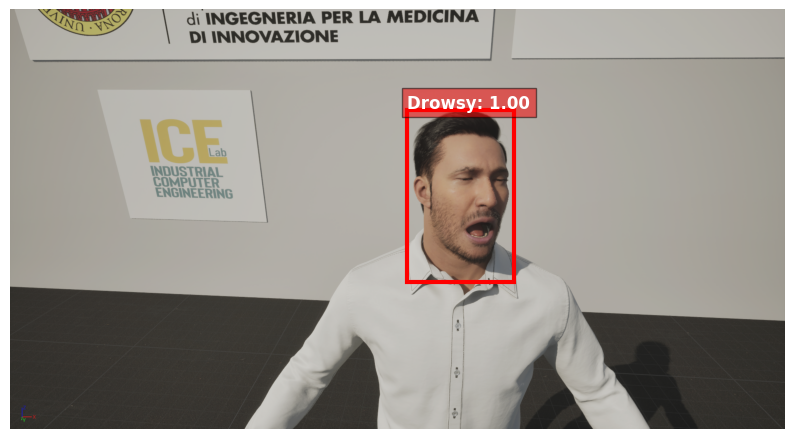

Labels: tensor([2])
Boxes: BoundingBoxes([[ 949.0003,  248.9999, 1256.0006,  666.0004]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


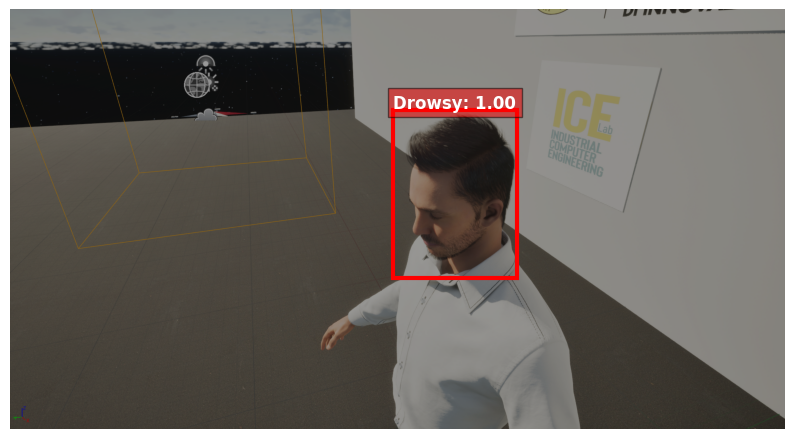

Labels: tensor([1])
Boxes: BoundingBoxes([[1098.0010,  239.9998, 1378.0004,  638.9999]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


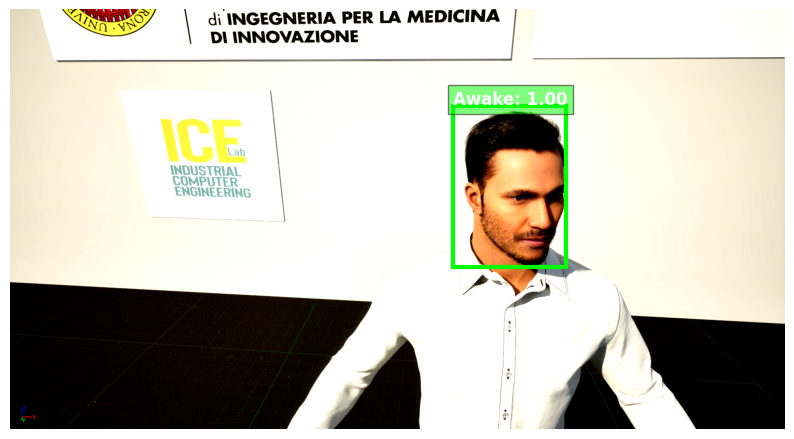

Labels: tensor([2])
Boxes: BoundingBoxes([[1120.9988,  243.9996, 1387.9996,  687.0001]], format=BoundingBoxFormat.XYXY, canvas_size=(1040, 1920), clamping_mode=soft)


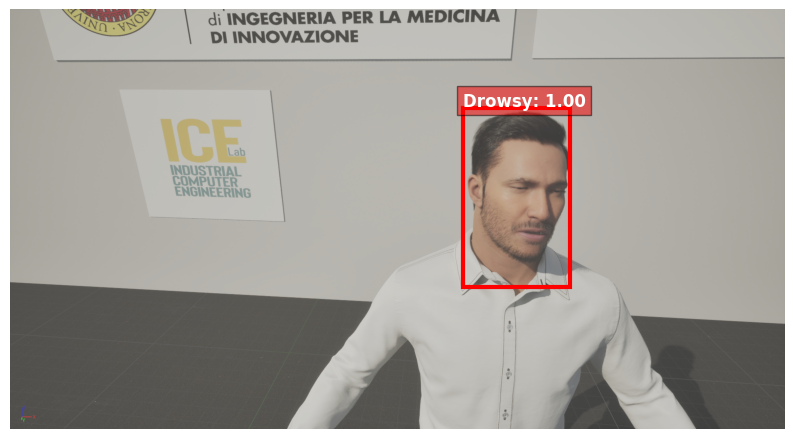

In [17]:
# --- 1. CARICAMENTO DATI ---
print("Caricamento Dataset...")

# Istanzi il Dataset
train_dataset = DigitalTwinDataset(
    root_dir=trainSet_path,
    transform=data_transform
)

# Istanzi il DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=2,         # Processi paralleli per caricare le immagini
    collate_fn=collate_fn
)

# check if dataset has correct label with bounding box
debug_dataset(train_dataset)

In [18]:
MODELS_ARCHS = [
    "resnet50",
    "mobilenet",
    "fasterrcnn_resnet50_fpn_v2"
]

In [23]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn, fasterrcnn_resnet50_fpn_v2

# Define the path in which you would like to save checkpoints of the weights of
# the model trained
save_dir = "/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/faster R-CNN"

# Training
MODEL_ARCH = "resnet50"

# Specify the dynamic path in base of the model choose
save_dir = os.path.join(save_dir,MODEL_ARCH)

# Create the folder if it doesn't exist
os.makedirs(save_dir,exist_ok=True)


if MODEL_ARCH == "resnet50":
    # Load DEFAULT weights (ImageNet/COCO)
    base_model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
elif MODEL_ARCH == "resnet50_v2":
    base_model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
elif MODEL_ARCH == "mobilenet":
    # Great for real-time
    base_model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
else:
    raise ValueError(f"Architecture {MODEL_ARCH} not supported")

# --- 2. MODEL LOADING ---
print("Loading Model...")
# 3 Classes: 0 = Background, 1 = Awake, 2 = Sleeping
model = get_my_model(base_model, num_classes=NUM_CLASSES)
model.to(DEVICE)

# --- 3. OPTIMIZER ---
# We use SGD
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE)

# --- 4. TRAINING LOOP ---
print(f"Starting Training on {DEVICE}...")

losses_list = []
for EPOCH in EPOCHS:
  print(f"starting the training of model: {model} for {EPOCH} epochs")
  for epoch in range(EPOCH):
      model.train()  # Sets the model to training mode (learning)
      epoch_loss = 0

      for i, (images, targets) in enumerate(train_loader):
          # A. MOVE DATA TO GPU
          # Images are a list of tensors
          images = list(image.to(DEVICE) for image in images)
          # Targets are a list of dictionaries (boxes, labels)
          targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

          # B. FORWARD PASS (Calculate error)
          # Faster R-CNN calculates losses automatically if you pass targets!
          loss_dict = model(images, targets)

          # loss_dict contains: loss_classifier, loss_box_reg, loss_objectness, etc.
          # We sum them all to get a single number to minimize
          losses = sum(loss for loss in loss_dict.values())

          # C. BACKWARD PASS (Update weights)
          optimizer.zero_grad()  # Zero out old gradients
          losses.backward()      # Calculate new gradients
          optimizer.step()       # Take a step in the right direction

          # D. MONITORING
          epoch_loss += losses.item()


      # End of epoch (Outside the 'i' loop, inside the 'epoch' loop)
      avg_loss = epoch_loss / len(train_loader)

      # average loss per epoch
      losses_list.append(avg_loss)

      print(f"--- END EPOCH {epoch+1} | Avg Loss: {avg_loss:.4f} ---")

      # --- 5. SAVING ---
      if (epoch + 1) % 100 == 0:
          save_path = os.path.join(save_dir, f"digital_twin_v1_epoch_{epoch+1}.pth")
          torch.save(model.state_dict(), save_path)

print("Training Completed!")

plt.plot(losses_list,label = "Mean loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

Loading Model...


AcceleratorError: CUDA error: invalid device ordinal
GPU device may be out of range, do you have enough GPUs?
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# --- Validation configuration ---
MODEL_WEIGHTS_PATH = "/content/gdrive/MyDrive/HC-DTs_ModelsAnalysis/faster R-CNN/resnet50/digital_twin_v1_epoch_100.pth"

# testSet = DigitalTwinDataset(testSet_path, get_transform(train=False))
val_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# --- CARICAMENTO MODELLO PER INFERENZA ---
# 1. Ricrea l'architettura vuota
base_model_eval = fasterrcnn_resnet50_fpn(weights="DEFAULT")
model_eval = get_my_model(base_model_eval, num_classes=3)

# 2. Loading weights saved
print(f"Loading weights from: {MODEL_WEIGHTS_PATH}")
checkpoint = torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE)
model_eval.load_state_dict(checkpoint)

model_eval.to(DEVICE)

# 3. evaluation
model_eval.eval()

print("Visualization...")

# --- CYCLE OF VISUALIZATION ---
num_images_to_show = 15

with torch.no_grad():
    for i, (images, targets) in enumerate(val_loader):
        if i >= num_images_to_show:
            break

        # move to GPU
        images = list(img.to(DEVICE) for img in images)

        # make prediction
        predictions = model_eval(images)

        # Mostra il risultato per la prima immagine del batch (batch_size=1)
        # Show the first
        print(f"--- Immagine {i+1} ---")
        show_inference(images[0], predictions[0], threshold=0.1)

In [ ]:
# --- Validation configuration ---
MODEL_PATH = ""

# testSet = DigitalTwinDataset(testSet_path, get_transform(train=False))
val_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# --- CARICAMENTO MODELLO PER INFERENZA ---
# 1. Ricrea l'architettura vuota
base_model_eval = fasterrcnn_resnet50_fpn(weights="DEFAULT")
model_eval = get_my_model(base_model_eval, num_classes=3)

# 2. Loading weights saved
print(f"Loading weights from: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model_eval.load_state_dict(checkpoint)

model_eval.to(DEVICE)

# 3. evaluation
model_eval.eval()
